# Multi-Task Training with Barlow Twins

### Import Necessary Packages

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import yaml

from config.datasets_config import DATASETS_CONFIG
from utils.datasets import get_generators, create_classifier_dataset
from utils.datasets import get_dataset_df
from utils.train.encoder import get_bt_datasets

### Load and Set Up Configuration Files

In [2]:
with open('config/encoder_config.yaml') as f:
    encoder_config = yaml.safe_load(f)
encoder_config['batch_size'] = 128
    
with open('config/classifier_config.yaml') as f:
    classifier_config = yaml.safe_load(f)
classifier_config['batch_size'] = 128
    
RANDOM_SEED = 42
encoder_config['random_seed'] = 42
classifier_config['random_seed'] = 42
overall_config = {
    'unlabeled_steps': None,
    'labeled_steps': None
}
overall_config['lr'] = 5e-3  # needs to be fine-tuned
overall_config['alpha'] = 1  # weighting term for SSL task

np.random.seed(RANDOM_SEED)
# tf.random.set_seed(RANDOM_SEED)

In [3]:
dataset_config = DATASETS_CONFIG[classifier_config['dataset_type']]
dataset_config['train_split'] = classifier_config['train_split']
dataset_config['validation_split'] = classifier_config['validation_split']

classifier_config['dataset_config'] = dataset_config
classifier_config['preprocessing_config'] = encoder_config['preprocessing_config']

### Load Datasets

In [4]:
# Copied from train_classifier.ipynb, combine later
def get_clf_datasets(dataset_config, config):
    dataset_config['train_split'] = config['train_split']
    dataset_config['validation_split'] = config['validation_split']

    # Load data generators
    datagen, datagen_val, datagen_test = get_generators(
        ['train', 'val', 'test'],
        config['image_shape'],
        batch_size=1,  # batched later
        random_seed=config['random_seed'],
        dataset_config=dataset_config
    )
    classes = list(datagen.class_indices.keys())
    config['classes'] = classes
    config['num_classes'] = len(classes)

    # Load class weight
    class_weight = None
    if config['use_class_weight']:
        with open(os.path.join(dataset_config['dataset_dir'], 'class_weight.json'), 'r') as f:
            class_weight = json.load(f)
        groups = dataset_config['groups']
        class_weight = {groups[k]: v for k, v in class_weight.items() if k in groups.keys()}
        class_weight = {datagen.class_indices[k]: v for k, v in class_weight.items()}
        print('Using class weights:', class_weight)
    config['class_weight'] = class_weight

    # Load datasets
    datasets, steps = [], []
    for gen in [datagen, datagen_val, datagen_test]:
        ds = create_classifier_dataset(gen, config['image_shape'], len(classes))
        ds = ds.batch(config['batch_size'])
        ds = ds.prefetch(config['prefetch'])

        steps.append(len(gen) // config['batch_size'])
        datasets.append(ds)
    config['steps'] = steps

    return datasets

In [5]:
def load_datasets(config, mode):
    # Retrieve datasets from either the unlabeled or labeled data
    # For unlabeled: returns [ds_a, ds_b]
    # For labeled: returns [ds_a, ds_b, ds_train, ds_val, ds_test], with 
    if mode not in ['unlabeled', 'labeled']:
        raise ValueError('`mode` must be either "unlabeled" or "labeled"')
    print(f'Loading {mode} datasets...')
    
    datagens = []
    tmp = {'labeled': 'classifier', 'unlabeled': 'encoder'}  # temporary measure
    df = get_dataset_df(config['dataset_config'], RANDOM_SEED, mode=tmp[mode])
    df = df.sample(frac=1).reset_index(drop=True)
    
    # Only train data (df['split'] == 'train') is used for the BT datasets
    ds_a, ds_b = get_bt_datasets(df, config)
    
    if mode == 'labeled':
        clf_datasets = [ds_a, ds_b]
        # Three datasets (train, val, test) for classification
        clf_datasets.extend(get_clf_datasets(config['dataset_config'], config))
        overall_config['labeled_steps'] = config['steps']
        return clf_datasets
    
    overall_config['unlabeled_steps'] = config['steps']
    return [ds_a, ds_b]

In [6]:
unlabeled_datasets = load_datasets(encoder_config, mode='unlabeled')
labeled_datasets = load_datasets(classifier_config, mode='labeled')

Loading unlabeled datasets...
Found 158001 validated image filenames belonging to 1 classes.
Found 158001 validated image filenames belonging to 1 classes.
Loading labeled datasets...
Found 11838 validated image filenames belonging to 6 classes.
Found 11838 validated image filenames belonging to 6 classes.
Found 11838 validated image filenames belonging to 6 classes.
Found 23677 validated image filenames belonging to 6 classes.
Found 20661 validated image filenames belonging to 6 classes.


In [7]:
classifier_config['steps']

[92, 184, 161]

In [8]:
from tensorflow.data import Dataset
dataset = Dataset.zip(tuple(unlabeled_datasets + labeled_datasets[:-2]))
dataset = dataset.prefetch(encoder_config['prefetch'])

In [9]:
test_batch = next(iter(dataset))

for imgs in test_batch:
    try:
        print(imgs.shape)
    except:
        print(imgs[0].shape, imgs[1].shape)

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3) (32, 6)


### Load Model

In [9]:
classifier_config['num_classes'] = 6

In [10]:
from utils.models.barlow_twins import compute_loss
from utils.models.resnet import projection_head
from tensorflow.keras.layers import Input
from tensorflow.keras.metrics import Accuracy
from utils.models.resnet import get_barlow_encoder
from utils.image_augmentation import get_blur_layer
from tensorflow.keras.layers import Dense
from tensorflow.distribute import MirroredStrategy
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient
from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.models import Model


class MultiTaskBT(tf.keras.Model):
    def __init__(self, encoder_config, classifier_config, alpha=1e-4):
        super(MultiTaskBT, self).__init__()
        
        self.resnet_enc = get_barlow_encoder(
            input_shape=encoder_config['image_shape'], 
            hidden_dim=encoder_config['projector_dim'], 
            hidden_layers=3,
            weights=encoder_config['weights']
        )
        self.resnet = self.resnet_enc.layers[1]
        
        self.blur_layer = get_blur_layer(encoder_config['filter_size'], encoder_config['image_shape'])
        
        inputs = Input((2048,))
        outputs = Dense(
            classifier_config['num_classes'], 
            activation='softmax', 
            kernel_initializer='he_normal'
        )(inputs)
        self.clf_head = Model(inputs=inputs, outputs=outputs)
        
        # Resnet encoder contains both the ResNet backbone and the BT Dense layers
#         self.trainable_vars = [
#             self.resnet_enc.trainable_variables,
#             self.clf_head.trainable_variables
#         ]
        
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        self.alpha = alpha
        
        # The reduction argument is a little confusing here
        self.cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        # Track loss + components
        self.loss_trackers =  [
            tf.keras.metrics.Mean(name='loss'),
            tf.keras.metrics.Mean(name='bt_loss'),
            tf.keras.metrics.Mean(name='clf_loss')
        ]
        
        # Metrics to track
        self.metric_trackers = [
            tf.keras.metrics.Mean(name='acc'),
            tf.keras.metrics.Mean(name='mcc'),
            tf.keras.metrics.Mean(name='auc')
        ]
        
        self.compute_acc = Accuracy()
        self.compute_mcc = MatthewsCorrelationCoefficient(num_classes=classifier_config['num_classes'])
        self.compute_auc = AUC(multi_label=True, num_thresholds=2000)

    def compute_metrics(self, y_true, y_pred):
        mcc = self.compute_mcc(y_true, y_pred)
        auc = self.compute_auc(y_true, y_pred)

        y_true = tf.math.argmax(y_true, axis=-1)
        y_pred = tf.math.argmax(y_pred, axis=-1)
        acc = self.compute_acc(y_true, y_pred)

        return [acc, mcc, auc]

    @property
    def metrics(self):
        return self.loss_trackers + self.metric_trackers
        
    def train_step(self, data):
        data = data[0]
        return_dict = {}
        
        with tf.GradientTape() as tape:
            # Encode data for BT task
            z_unlabeled_a, z_unlabeled_b = self.resnet_enc(data[0]), self.resnet_enc(data[1])
            z_labeled_a, z_labeled_b = self.resnet_enc(data[2]), self.resnet_enc(data[3])

            # Compute loss for aux task
            bt_loss = compute_loss(z_unlabeled_a, z_unlabeled_b, 5e-3) + \
                      compute_loss(z_labeled_a, z_labeled_b, 5e-3)
            bt_loss *= self.alpha

            # Compute loss for classification task
            z_clf = self.resnet(data[4][0])  # raw output from the resnet
            clf_preds = self.clf_head(z_clf)
            clf_loss = self.cce(data[4][1], clf_preds)

            # Compute total loss
            loss_total = bt_loss + clf_loss
        
        # Compute and apply gradients
        gradients = tape.gradient(loss_total, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
#         print(len(gradients), gradients)
#         for i, variables in enumerate(self.trainable_variables):
#             self.optimizer.apply_gradients(zip(gradients[i], variables))
        
        # Compute and update metrics
        metrics = self.compute_metrics(data[4][1], clf_preds)
        for i, tracker in enumerate(self.metric_trackers):
            tracker.update_state(metrics[i])
            return_dict[tracker.name] = tracker.result()
#             return_dict[tracker.name] = metrics[i]
        
        # Update losses, bt_loss is scaled back to its original value
        losses = [loss_total, bt_loss / self.alpha, clf_loss]
        for i, tracker in enumerate(self.loss_trackers):
            tracker.update_state(losses[i])
            return_dict[tracker.name] = tracker.result()
        
        return return_dict
    
    def test_step(self, data):
        return_dict = {}
        
        z_clf = self.resnet(data[0])
        clf_preds = self.clf_head(z_clf)
        clf_loss = self.cce(data[1], clf_preds)
        
        self.loss_trackers[0].update_state(clf_loss)
        return_dict['clf_loss'] = self.loss_trackers[0].result()
        
        metrics = self.compute_metrics(data[1], clf_preds)
        for i, tracker in enumerate(self.metric_trackers):
            tracker.update_state(metrics[i])
            return_dict[tracker.name] = tracker.result()
            
        return return_dict
    
    def call(self, data, **kwargs):
        return None

In [11]:
gpus = [f'GPU:{i}' for i in range(4)]
strategy = MirroredStrategy(gpus)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [12]:
with strategy.scope():
    model = MultiTaskBT(encoder_config, classifier_config, alpha=1e-3)
    model.compile()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [13]:
def get_generator():
    while True:
        yield next(iter(dataset)), None
        
dataset_gen = get_generator()

In [57]:
# len(model.trainable_vars[0]), len(model.trainable_vars[1]), len(model.resnet.trainable_variables), len(model.trainable_variables)

(186, 2, 172, 188)

In [14]:
model.clf_head.trainable_variables

[MirroredVariable:{
   0: <tf.Variable 'dense/kernel:0' shape=(2048, 6) dtype=float32, numpy=
 array([[ 0.02193215,  0.01094406,  0.02443562,  0.03891384, -0.00886312,
          0.01221845],
        [ 0.03607156,  0.03848896,  0.06626374, -0.00056959,  0.02669743,
          0.06803922],
        [-0.05875125,  0.00424939,  0.0140915 ,  0.06916474, -0.01466475,
         -0.01503121],
        ...,
        [ 0.03259342,  0.03002945, -0.02316513, -0.00137625, -0.01731246,
          0.02095407],
        [-0.02037512,  0.02793866, -0.01058   ,  0.05827345,  0.03099076,
         -0.00573598],
        [-0.0347876 , -0.00789304,  0.02864905,  0.022351  ,  0.04868171,
         -0.01359881]], dtype=float32)>,
   1: <tf.Variable 'dense/kernel/replica_1:0' shape=(2048, 6) dtype=float32, numpy=
 array([[ 0.02193215,  0.01094406,  0.02443562,  0.03891384, -0.00886312,
          0.01221845],
        [ 0.03607156,  0.03848896,  0.06626374, -0.00056959,  0.02669743,
          0.06803922],
        [-0.058

In [ ]:
history = model.fit(
    dataset_gen, 
    epochs=10,
    steps_per_epoch=encoder_config['steps'],
    validation_data=labeled_datasets[-2],  # not labeled_datasets[2]
    validation_steps=classifier_config['steps'][1]
)

import pickle
with open('history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/10
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 188 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 188 all-reduces with algorithm = nccl, num_packs = 1
1235/1235 [==============================] - 4538s 4s/step - acc: 0.4016 - mcc: 0.0058 - auc: 0.4918 - loss: 26.6560 - bt_loss: 13665.1631 - clf_loss: 12.9908 - val_clf_loss: 1.5130 - val_acc: 0.4041 - val_mcc: 0.0055 - val_auc: 0.4959
Epoch 2/10
1235/1235 [==============================] - 4523s 4s/step - acc: 0.4061 - mcc: 0.0060 - auc: 0.4967 - loss: 15.1529 - bt_loss: 13702.0215 - clf_loss: 1.4508 - val_clf_loss: 1.8099 - val_acc: 0.4053 - val_mcc: 0.0071 - val_auc: 0.4976
Epoch 3/10
1235/1235 [==============================] - 4527s 4s/step - acc: 0.4047 - mcc: 0.0079 - auc: 0.4978 - loss: 14.7704 - bt_loss: 13318.6357 - clf_loss: 1.4518 - val_clf_loss: 1.3811 - val_acc: 0.4045 - val_mcc: 0.0080 - val_auc: 0.4978
Epoch

In [35]:
model.summary()

Model: "multi_task_bt_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_9 (Functional)    (None, 4096)              82350592  
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
functional_11 (Functional)   (None, 224, 224, 3)       1587      
_________________________________________________________________
dense_2 (Dense)              multiple                  12294     
_________________________________________________________________
loss (Mean)                  multiple                  2         
_________________________________________________________________
bt_loss (Mean)               multiple                  2         
_________________________________________________________________
clf_loss (Mean)              multiple              

In [31]:
model.evaluate(labeled_datasets[2 + 0], steps=classifier_config['steps'][0])

369/369 [==============================] - 41s 112ms/step - clf_loss: 1.0334 - acc: 0.5096 - mcc: 0.2252 - auc: 0.6906


[None,
 None,
 1.0333515405654907,
 0.5096120238304138,
 0.22521322965621948,
 0.6905840039253235]

In [24]:
history.history

{'acc': [0.39987754821777344,
  0.41108155250549316,
  0.4088605046272278,
  0.4116807281970978,
  0.4156692922115326,
  0.4390472173690796,
  0.45051416754722595,
  0.4809083938598633,
  0.5019717812538147,
  0.509554386138916],
 'mcc': [0.004768026527017355,
  0.009822017513215542,
  0.00956168957054615,
  0.007953873835504055,
  0.014087055809795856,
  0.08008313179016113,
  0.1062018871307373,
  0.16863501071929932,
  0.20926059782505035,
  0.22454339265823364],
 'auc': [0.5001043081283569,
  0.5029935240745544,
  0.503224790096283,
  0.5021206736564636,
  0.508043110370636,
  0.5648289322853088,
  0.5897824168205261,
  0.6428418159484863,
  0.6760104894638062,
  0.6884757280349731],
 'loss': [9.17133617401123,
  8.17397689819336,
  8.156031608581543,
  10.305830955505371,
  8.795276641845703,
  8.755908012390137,
  3188.197021484375,
  4024.417236328125,
  111985.109375,
  5375.06982421875],
 'bt_loss': [13544.138671875,
  13535.85546875,
  13527.486328125,
  13282.7080078125,
  1

In [26]:
for i in range(200):
    history = model.train_step(test_batch)
    if i % 1 == 0:
        print(history)

{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.62577736>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6840928>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6260848>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6820837>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6264416>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6798049>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.62684715>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6778631>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.62730086>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6747582>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6277012>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.6731836>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.62813485>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.670526>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.628513>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.

{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6570113>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5250889>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6575746>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5221949>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.65813816>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.519316>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6587017>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5164598>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6592652>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5136232>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.65982854>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5108043>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.66039157>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.5080065>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.66095424>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1

{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6914131>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.372404>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6918912>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.370513>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6923676>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.368632>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6928424>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3667603>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6933155>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3648976>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.69378704>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3630441>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.6942569>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3611991>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.69472516>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.359

{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.71929955>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.2661166>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.71968234>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.2647306>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.72006387>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.2633513>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.7204442>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.2619787>}
{'acc': <tf.Tensor: shape=(), dtype=float32, numpy=0.7208232>, 'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.2606131>}


In [25]:
model.metric_trackers[0][2] = tf.keras.metrics.Mean(name='acc')

In [13]:
z_clf = model.resnet(test_batch[4][0])  # raw output from the resnet
clf_preds = model.clf_head(z_clf)

In [15]:
np.max(clf_preds, axis=-1)

array([0.54619634, 0.5520442 , 0.5455562 , 0.535429  , 0.5428875 ,
       0.5468257 , 0.57551914, 0.5795539 , 0.5181653 , 0.5272922 ,
       0.53670055, 0.5264938 , 0.5152191 , 0.53905845, 0.56988555,
       0.56970245, 0.5401192 , 0.5213315 , 0.57494396, 0.5590648 ,
       0.54875153, 0.5508399 , 0.5945423 , 0.5535417 , 0.58148867,
       0.56921184, 0.5555371 , 0.5521625 , 0.544279  , 0.56606144,
       0.57081664, 0.5225052 ], dtype=float32)

In [14]:
compute_acc(test_batch[4][1], clf_preds)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [36]:
gpus = [f'GPU:{i}' for i in range(4)]

In [17]:
from utils.models.resnet import get_barlow_encoder
from utils.image_augmentation import get_blur_layer
from tensorflow.keras.layers import Dense
from tensorflow.distribute import MirroredStrategy

strategy = MirroredStrategy(gpus)

# with strategy.scope():
resnet_enc = get_barlow_encoder(
    input_shape=encoder_config['image_shape'], 
    hidden_dim=encoder_config['projector_dim'], 
    hidden_layers=3,
    weights=encoder_config['weights']
)
resnet = resnet_enc.layers[1]

blur_layer = get_blur_layer(encoder_config['filter_size'], encoder_config['image_shape'])

clf_head = Dense(
    classifier_config['num_classes'], 
    activation='softmax', 
    kernel_initializer='he_normal'
)

cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-4)

NameError: name 'gpus' is not defined

In [75]:
optimizer = tf.keras.optimizers.Adam(1e-5)

In [78]:
for i in range(100):
    with tf.GradientTape() as tape:
        z_unlabeled_a, z_unlabeled_b = resnet_enc(test_batch[0]), resnet_enc(test_batch[1])
        z_labeled_a, z_labeled_b = resnet_enc(test_batch[2]), resnet_enc(test_batch[3])

        bt_loss_unlabeled = compute_loss(z_unlabeled_a, z_unlabeled_b, 5e-3)
        bt_loss_labeled = compute_loss(z_labeled_a, z_labeled_b, 5e-3)

        z_clf = resnet(test_batch[4][0])  # raw output from the resnet
        clf_preds = clf_head(z_clf)
        clf_loss = cce(test_batch[4][1], clf_preds)

        alpha = 0.0001  # considering that bt loss could be in the thousands...
        bt_loss = alpha * (bt_loss_unlabeled + bt_loss_labeled)
        loss = bt_loss + clf_loss
        if i % 20 == 0:
            print(i, bt_loss.numpy(), clf_loss.numpy())

    trainable_variables = [
        resnet_enc.trainable_variables,
        clf_head.trainable_variables
    ]
    gradients = tape.gradient(loss, trainable_variables)

    for i, variables in enumerate(trainable_variables):
        optimizer.apply_gradients(zip(gradients[i], variables))

0 1.4696548 0.017756656
20 0.82632506 0.016311558
40 0.7877851 0.005291387
60 0.77913886 0.002981678
80 0.7787413 0.0019638427


In [79]:
from tensorflow.keras.metrics import Accuracy

acc = Accuracy()
acc(np.argmax(test_batch[4][1], axis=-1), np.argmax(clf_preds, axis=-1))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [42]:
z_unlabeled_a, z_unlabeled_b = resnet_enc(test_batch[0]), resnet_enc(test_batch[1])
z_labeled_a, z_labeled_b = resnet_enc(test_batch[2]), resnet_enc(test_batch[3])
print(z_unlabeled.shape)

(256, 4096)


In [43]:
bt_loss_unlabeled = compute_loss(z_unlabeled_a, z_unlabeled_b, 5e-3)
bt_loss_labeled = compute_loss(z_labeled_a, z_labeled_b, 5e-3)
print(bt_loss_unlabeled)

tf.Tensor(3771.2751, shape=(), dtype=float32)


In [45]:
z_clf = resnet(test_batch[4][0])  # raw output from the resnet
clf_preds = clf_head(z_clf)
clf_loss = cce(test_batch[4][1], clf_preds)
print(z_clf.shape, clf_preds.shape)
print(clf_loss)

(256, 2048) (256, 6)
tf.Tensor(1.8073874, shape=(), dtype=float32)


In [48]:
alpha = 0.001  # considering that bt loss could be in the thousands...
loss = alpha * (bt_loss_unlabeled + bt_loss_labeled) + clf_loss
print(loss)

In [45]:
len(test_batch)

6

In [16]:
trainable_variables = [
    resnet_enc.trainable_variables,
    clf_head.trainable_variables
]
gradients = tape.gradient(loss, trainable_variables)

for i, variables in enumerate(trainable_variables):
    optimizer.apply_gradients(zip(gradients[i], variables))

In [14]:
model = MultiTaskBT(resnet_enc, blur_layer)
X = np.random.randn(20, 1).astype('float32')
y = X * 2

<tf.Tensor: shape=(), dtype=float32, numpy=12.567465>

In [279]:
for i in range(3000):
    loss = model.train_step((X, y))
    if i % 300 == 0:
        print(i, loss)

0 {'clf_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.346493>}
300 {'clf_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.077263884>}
600 {'clf_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.038696222>}
900 {'clf_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.025811797>}
1200 {'clf_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.019364221>}
1500 {'clf_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.015493956>}
1800 {'clf_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.012913064>}
2100 {'clf_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.011069219>}
2400 {'clf_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.009686142>}
2700 {'clf_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.008634655>}


In [280]:
model.clf_head(model.encoder(X))

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[-5.4261103 ],
       [-0.299671  ],
       [-2.8631582 ],
       [-0.95383   ],
       [-0.59838283],
       [-0.7172247 ],
       [-1.1052364 ],
       [-2.193758  ],
       [ 4.581831  ],
       [ 3.733179  ],
       [-2.3249211 ],
       [ 3.1626537 ],
       [-0.79966223],
       [ 0.25758386],
       [-0.12731734],
       [-1.320199  ],
       [ 1.9664721 ],
       [ 0.25098217],
       [-0.95382524],
       [-2.6107347 ]], dtype=float32)>

In [15]:
from tensorflow.keras.layers import Dense

classifier_config['num_classes']

6

### Visualizations/Debugging

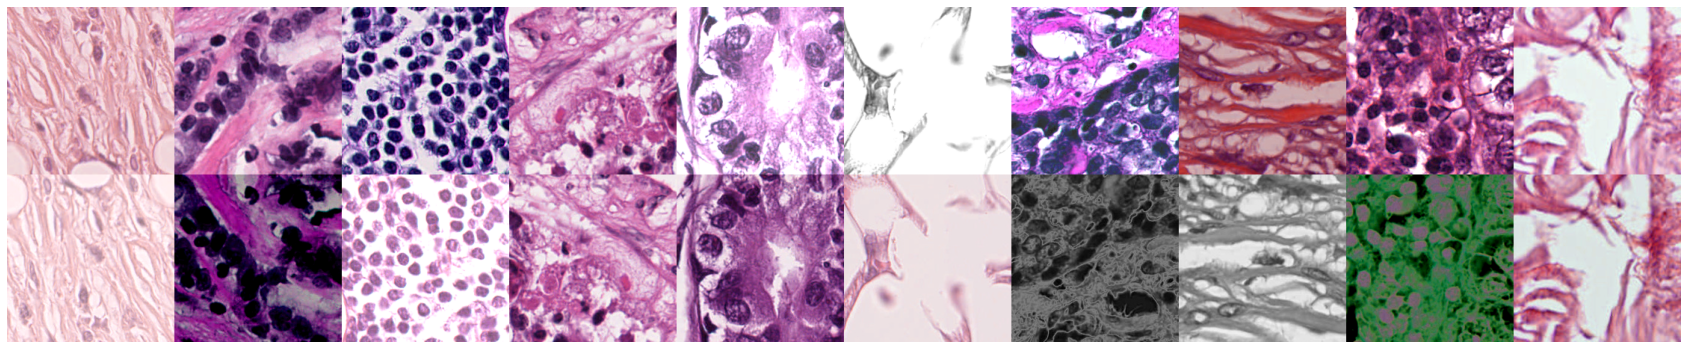

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# batch_a, batch_b = iter(unlabeled_datasets[0]).next(), iter(unlabeled_datasets[1]).next()
batch_a, batch_b = iter(labeled_datasets[0]).next(), iter(labeled_datasets[1]).next()

plt.figure(figsize=(30, 20))
plt.imshow(np.vstack([
    np.hstack(batch_a[0:10]), 
    np.hstack(batch_b[0:10])
]))
plt.axis('off')
plt.show()